In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
import tensorflow as tf
from tensorflow import keras


from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from keras.optimizers import Adam
from keras import backend as K
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import *
from keras import initializers
from keras.layers import BatchNormalization

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


In [ ]:
def data_generator(imgs, masks, batch_size=1):
    num_samples = len(imgs)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_imgs = imgs[indices]
        batch_masks = masks[indices]
        yield batch_imgs, batch_masks

In [ ]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    smooth = 0.
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0

    # Flatten the true and predicted masks
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    dice_coeff_class_0 = (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) + smooth)

    y_true_class_1 = 1 - y_true
    y_pred_class_1 = 1 - y_pred

    y_true_flat_class_1 = tf.keras.backend.flatten(y_true_class_1)
    y_pred_flat_class_1 = tf.keras.backend.flatten(y_pred_class_1)

    intersection_class_1 = tf.keras.backend.sum(y_true_flat_class_1 * y_pred_flat_class_1)
    dice_coeff_class_1 = (2.0 * intersection_class_1 + smooth) / (tf.keras.backend.sum(y_true_flat_class_1) + tf.keras.backend.sum(y_pred_flat_class_1) + smooth)

    # Calculate the mean of both Dice coefficients
    dice_coefficient = (dice_coeff_class_0 + dice_coeff_class_1) / 2.0
    return dice_coefficient

def weighted_dice_coef_loss(y_true, y_pred):

    return 1.0 - dice_coef(y_true, y_pred)



In [ ]:
def get_unet_small():
    inputs = Input((512,512,1))
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu',padding='same', name='conv_1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv1)
    pool1 = BatchNormalization()(pool1)

    conv2 = Conv2D(64, (3, 3), activation='elu',padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu',padding='same', name='conv_2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv2D(128, (3, 3), activation='elu',padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu',padding='same', name='conv_3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool_3')(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv2D(256, (3, 3), activation='elu',padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='elu',padding='same', name='conv_4')(conv4)
    conv4 = BatchNormalization()(conv4)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3],axis = 3)
    conv7 = Conv2D(128, (3, 3), activation='elu',padding='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='elu',padding='same', name='conv_7')(conv7)
    conv7 = BatchNormalization()(conv7)

    #up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2],axis = 3)
    conv8 = Conv2D(64, (3, 3), activation='elu',padding='same')(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='elu',padding='same', name='conv_8')(conv8)
    conv8 = BatchNormalization()(conv8)

    #up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1],axis = 3)
    conv9 = Conv2D(32, (3, 3), activation='elu',padding='same')(up9)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='elu',padding='same', name='conv_9')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', name='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.summary()
    # Compile the model with the custom loss function and optimizer

    model.compile(optimizer='adam', loss=weighted_dice_coef_loss, metrics=[dice_coefficient])

    optimizer = Adam(learning_rate=0.00016815389884367667)
    model.compile(optimizer=optimizer, loss=weighted_dice_coef_loss, metrics=['accuracy', dice_coefficient])

    return model

In [ ]:
model = get_unet_small()
model.save("/content/drive/MyDrive/LUNA16/u_net_ori.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         320       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv_1 (Conv2D)             (None, 512, 512, 32)         9248      ['dropout[0][0]']             
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:


# Load the model architecture and create the model object (if needed)
# Assuming you have defined the model architecture somewhere
print('Creating and compiling model...')
model = get_unet_small()

# Specify the path to the HDF5 file containing the saved model weights
weights_path = '/content/drive/MyDrive/LUNA16/U-netModel_hyperparameter_tuning_0.00016815389884367667.hdf5'

# Load the model weights from the HDF5 file
model.load_weights(weights_path)

print("Done")


Creating and compiling model...
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 512, 512, 32)         320       ['input_3[0][0]']             
                                                                                                  
 dropout_14 (Dropout)        (None, 512, 512, 32)         0         ['conv2d_14[0][0]']           
                                                                                                  
 conv_1 (Conv2D)             (None, 512, 512, 32)         9248      ['dropout_14[0][0]']          
                                                            

ValueError: ignored

In [ ]:
model.save("/content/drive/MyDrive/LUNA16/u_net.h5")

In [ ]:
# Step 2: Load the test images and masks
print("Start loading test set")
# Load and preprocess test data
test_images = np.load('/content/drive/MyDrive/LUNA16/testImages.npy').astype(np.float16)
test_masks = np.load('/content/drive/MyDrive/LUNA16/testMasks.npy').astype(np.float16)
print("Finish loading test set")

# Step 3: Preprocess the test images (you might need to adapt this based on your preprocessing steps during training)
print("Start transpose test set")
test_images = test_images.transpose(0, 2, 3, 1)
test_masks = test_masks.transpose(0, 2, 3, 1)
test_masks[test_masks > 0] = 1.0
print("Finish transpose test set")



Start loading test set
Finish loading test set
Start transpose test set
Finish transpose test set


In [ ]:

from skimage.measure import label, regionprops
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from datetime import datetime
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import pytz

# Specify the Malaysia time zone
malaysia_time_zone = pytz.timezone('Asia/Kuala_Lumpur')

y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(np.float16)

print("Y_pred_binary : ", y_pred_binary.shape)
# Define your min and max size thresholds
min_size = 600


# Initialize an array for filtered binary predictions
filtered_pred_binary = np.zeros_like(y_pred_binary)

for i in range(len(y_pred_binary)):
    labeled_regions = label(y_pred_binary[i])

    region_props = regionprops(labeled_regions)
    for region in region_props:
        region_area = region.area
        if min_size <= region_area :
            filtered_pred_binary[i][labeled_regions == region.label] = 1
print("filtered_pred_binary : ", filtered_pred_binary.shape)
print("Generating report ... ")


start_time = datetime.now(malaysia_time_zone)
start_formatted_time = start_time.strftime("%I:%M %p")
print("Start time : ", start_formatted_time)
# Evaluate the filtered predictions using appropriate metrics
filtered_classification_rep = classification_report(test_masks.flatten(), filtered_pred_binary.flatten())
end_time = datetime.now(malaysia_time_zone)
end_formatted_time = end_time.strftime("%I:%M %p")

accuracy = accuracy_score(test_masks.flatten(), filtered_pred_binary.flatten())
accuracy_percentage = accuracy * 100  # Convert accuracy to percentage

# Format and print the accuracy as a percentage with two decimal places
formatted_accuracy = "{:.2f}".format(accuracy_percentage)
print("Accuracy:", formatted_accuracy, "%")

print("End time : " , end_formatted_time)
# Print the metrics for filtered predictions
print("Filtered Classification Report:")
print(filtered_classification_rep)


21/21 [==============================] - 14s 705ms/step
Y_pred_binary :  (647, 512, 512, 1)
filtered_pred_binary :  (647, 512, 512, 1)
Generating report ... 
Start time :  02:56 PM
Accuracy: 99.55 %
End time :  03:31 PM
Filtered Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00 165203890
         1.0       0.95      0.87      0.91   4403278

    accuracy                           1.00 169607168
   macro avg       0.97      0.94      0.95 169607168
weighted avg       1.00      1.00      1.00 169607168



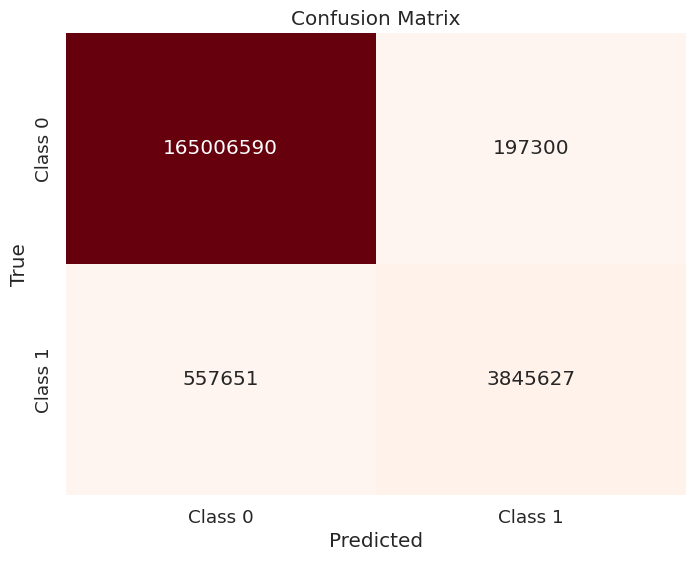

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
confusion = confusion_matrix(test_masks.flatten(), filtered_pred_binary.flatten())

# Plot the confusion matrix as a heatmap with custom colors
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
# Extract values from the confusion matrix
TN, FP, FN, TP = confusion.ravel()

# Calculate sensitivity (True Positive Rate or Recall)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
# Print the sensitivity value
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Sensitivity: 0.7872
Specificity: 0.9988


In [ ]:
import cv2
import matplotlib.pyplot as plt

for i in range(len(test_images)):
    image = test_images[i, ..., 0]  # Extract the first channel (assuming single-channel images)
    mask = filtered_pred_binary[i, ..., 0]  # Use filtered predictions
    test_mask = test_masks[i, ..., 0]

    # Convert the mask to the appropriate data type (CV_8UC1)
    mask = (mask * 255).astype(np.uint8)

    # Use OpenCV to find contours in the binary mask (detected nodules)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert the image to the appropriate data type and rescale values for proper display
    image_with_circles = (image * 255).astype(np.uint8)

    # Convert the grayscale image to RGB format
    image_with_circles = cv2.cvtColor(image_with_circles, cv2.COLOR_GRAY2RGB)

    # Draw circles around detected nodules on the original image
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image_with_circles, center, radius, (255, 0, 0), 2)  # Change the color to red (BGR: Blue, Green, Red)

    # Plot the image with circles and the test mask
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_with_circles)
    plt.title(f"Test Image {i + 1} with Detected Nodules")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(test_mask, cmap='gray')
    plt.title(f"Test Mask {i + 1}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()